## Interactive Decision Tree from Predictive Machine Learning


### The Interactive Workflow

Here's a simple workflow, demonstration of decision trees for subsurface modeling workflows. This should help you get started with building subsurface models that data analytics and machine learning. 


### Decision Tree

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of support vector machines.

**Prediction**

* estimate a function $\hat{f}$ such that we predict a response feature $Y$ from a set of predictor features $X_1,\ldots,X_m$. 

* the prediction is of the form $\hat{Y} = \hat{f}(X_1,\ldots,X_m)$ 

**Suppervised Learning**

* the response feature label, $Y$, is available over the training and testing data
    
**Hiearchical, Binary Segmentation of the Feature Space**

The fundamental idea is to divide the predictor space, $𝑋_1,\ldots,X_m$, into $J$ mutually exclusive, exhaustive regions

* **mutually exclusive** – any combination of predictors only belongs to a single region, $R_j$

* **exhaustive** – all combinations of predictors belong a region, $R_j$, regions cover entire feature space (range of the variables being considered)

For every observation in a region, $R_j$, we use the same prediction, $\hat{Y}(R_j)$    

For example predict production, $\hat{Y}$, from porosity, ${X_1}$

* given the data within a mD feature space, $X_1,\ldots,X_m$, find that boundary maximizes the gap between the two categories

* new cases are classified based on where they fall relative to this boundary 

**Compact, Interpretable Model**

Since the classification is based on a hierarchy of binary segmentations of the feature space (one feature at a time) the the model can be specified in a intuitive manner as a:

* **tree with binary branches**, hence the name decision tree

* **set of nested if statements**, for example:

```python
if porosity > 0.15:
    if brittleness < 20:
        initial_production = 1000
    else:
        initial_production = 7000
else:
    if brittleness < 40:
        initial_production = 500
    else:
        initial_production = 3000
```

* **predicts with the average of training response features** in each region $\hat{Y}(R_j)$.   

**Proceedure for Tree Construction**

The tree is constructed from the top down.  We begin with a sigle region that covers the entire feature space and then proceed with a sequence of splits.

* **Scan All Possible Splits** over all regions and over all features.

* **Greedy Optimization**  The method proceeds by finding the first segmentation (split) in any feature that minimizes the residual sum of squares of errors over all the training data $y_i$ over all of the regions $j = 1,\ldots,J$.

\begin{equation}
RSS = \sum^{J}_{j=1} \sum_{i \in R_j} (y_i - \hat{y}_{R_j})^2
\end{equation}

* **Stopping Criteria** is typically based on minimum number of training data in each region for a robust estimation and / or minimum reduction in RSS for the next split 

##### Applications to Subsurface Modeling

To provide a wide variety of spatiotemporal  

* we work with just 2 predictor features for the example below for easy visualization

* flexibility through selection of kernel (hyperparameter) and associated kernel and cost parameters 


##### Why Cover Decision Trees?

They are not the most powerful, cutting edge method in machine learning

* but they are likely the most understandable, interpretable  

* decision trees are expanded with random forests, bagging and boosting to be cutting edge  


#### Install Packages

We will include the standard packages for DataFrames and ndarrays and add sci-kit-learn (sklearn) for machine learning.

In [1]:
%matplotlib inline
supress_warnings = False
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from sklearn.model_selection import train_test_split    # train and test split
from sklearn import tree                                # tree program from scikit learn (package for machine learning)
from sklearn import metrics                             # measures to check our models
from sklearn.utils.validation import check_is_fitted
from matplotlib.patches import Rectangle                # build a custom legend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import math                                             # sqrt operator
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
cmap = plt.cm.inferno                                   # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                          # grid behind plotting elements
if supress_warnings == True:
    import warnings                                     # supress any warnings for this demonstration
    warnings.filterwarnings('ignore')                       

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

These are functions that I wrote (with one exception) to diagnose and visualize decision tree models.

* **extract_rules** - recursive function to get the rules for each devision tree region as a set of conditional statements. Note there is some repeat. I found this on Stack Overflow (I think paulkernfeld was the author).

* **plot_decision_tree_regions** - inspired by rstats' tree package, this function takes the extract_rules output to add the tree prediction regions to a plot. Note, only works with 2 predictor features.

* **visualize_tree_model** - plot the data in feature space and a grid of the tree predictions. Note, only works for 2 predictor features.

* **check_tree_model** - cross validation plot with prediction vs. true for testing and training data. Shows the region values and conditional statistics for the true values in each region (P10, mean and P90)

* **tree_tuning** - vary the tree complexity via the number of regions (a.k.a. max_leaf_nodes) hyperparameter and plot the mean square error (MSE) training and testing along with the currently displayed model to visually hyperparameter tune.

I'm stoked about these functions. They provide a great improvement in diagnosing and visualizing decision tree models in predictive machine learning.

In [2]:
def extract_rules(tree_model, feature_names):           # recursive method to extract rules, from paulkernfeld Stack Overflow (?)
    rules = []
    def traverse(node, depth, prev_rule):
        if tree_model.tree_.children_left[node] == -1:  # Leaf node
            class_label = np.argmax(tree_model.tree_.value[node])
            rule = f"{prev_rule} => Class {class_label}"
            rules.append(rule)
        else:  # Split node
            feature = feature_names[tree_model.tree_.feature[node]]
            threshold = tree_model.tree_.threshold[node]
            left_child = tree_model.tree_.children_left[node]
            right_child = tree_model.tree_.children_right[node]

            # Recursively traverse left and right subtrees
            traverse(left_child, depth + 1, f"{prev_rule} & {feature} <= {threshold}")
            traverse(right_child, depth + 1, f"{prev_rule} & {feature} > {threshold}")
    traverse(0, 0, "Root")
    return rules

def plot_decision_tree_regions(tree_model, feature_names,X_min,X_max):
    rules = extract_rules(tree_model, feature_names)
    for irule, ____ in enumerate(rules):
        rule = rules[irule].split()[2:]
        X_min = Xmin[0]; X_max = Xmax[0]; Y_min = Xmin[1]; Y_max = Xmax[1];
        index = [i for i,val in enumerate(rule) if val==feature_names[0]]
        for i in index:
            if rule[i+1] == '<=':
                X_max = min(float(rule[i+2]),X_max)
            else:
                X_min = max(float(rule[i+2]),X_min)
        index = [i for i,val in enumerate(rule) if val==feature_names[1]]
        for i in index:
            if rule[i+1] == '<=':
                Y_max = min(float(rule[i+2]),Y_max)
            else:
                Y_min = max(float(rule[i+2]),Y_min) 
        plt.gca().add_patch(plt.Rectangle((X_min,Y_min),X_max-X_min,Y_max-Y_min, lw=2,ec='black',fc="none"))
        cx = (X_min + X_max)*0.5; cy = (Y_min + Y_max)*0.5; loc = np.array((cx,cy)).reshape(1, -1)
        plt.annotate(text = str(np.round(tree_model.predict(loc)[0],2)),xy=(cx,cy),ha='center',weight='bold',c='white',zorder=100)

def visualize_tree_model(model,X1_train,X1_test,X2_train,X2_test,Xmin,Xmax,y_train,y_test,ymin,ymax,title,Xname,yname,Xlabel,ylabel):# plots the data points and the decision tree prediction 
    cmap = plt.cm.inferno
    X1plot_step = (Xmax[0] - Xmin[0])/300.0; X2plot_step = -1*(Xmax[1] - Xmin[1])/300.0 # resolution of the model visualization
    XX1, XX2 = np.meshgrid(np.arange(Xmin[0], Xmax[0], X1plot_step), # set up the mesh
                     np.arange(Xmax[1], Xmin[1], X2plot_step))
    y_hat = model.predict(np.c_[XX1.ravel(), XX2.ravel()]) # predict with our trained model over the mesh
    y_hat = y_hat.reshape(XX1.shape)

    plt.imshow(y_hat,interpolation=None, aspect="auto", extent=[Xmin[0],Xmax[0],Xmin[1],Xmax[1]], 
        vmin=ymin,vmax=ymax,alpha = 0.2,cmap=cmap,zorder=1)
    sp = plt.scatter(X1_train,X2_train,s=None, c=y_train, marker='o', cmap=cmap, 
        norm=None, vmin=ymin, vmax=ymax, alpha=0.6, linewidths=0.3, edgecolors="black", label = 'Train',zorder=10)
    plt.scatter(X1_test,X2_test,s=None, c=y_test, marker='s', cmap=cmap, 
        norm=None, vmin=ymin, vmax=ymax, alpha=0.3, linewidths=0.3, edgecolors="black", label = 'Test',zorder=10)

    plot_decision_tree_regions(model,Xname,Xmin,Xmax)
    plt.title(title); plt.xlabel(Xlabel[0]); plt.ylabel(Xlabel[1])
    plt.xlim([Xmin[0],Xmax[0]]); plt.ylim([Xmin[1],Xmax[1]])
    cbar = plt.colorbar(sp, orientation = 'vertical')   # add the color bar
    cbar.set_label(ylabel, rotation=270, labelpad=20)
    return y_hat

def check_tree_model(model,X1_train,X1_test,X2_train,X2_test,Xmin,Xmax,y_train,y_test,ymin,ymax,title):    # plots the estimated vs. the actual  
    y_hat_train = model.predict(np.c_[X1_train,X2_train]); y_hat_test = model.predict(np.c_[X1_test,X2_test])

    df_cross = pd.DataFrame(np.c_[y_test,y_hat_test],columns=['y_test','y_hat_test'])
    df_cross_train = pd.DataFrame(np.c_[y_train,y_hat_train],columns=['y_train','y_hat_train'])

    plt.scatter(y_train,y_hat_train,s=15, c='blue',marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=0.7, 
                linewidths=0.3, edgecolors="black",label='Train',zorder=10)
    plt.scatter(y_test,y_hat_test,s=15, c='red',marker='s', cmap=None, norm=None, vmin=None, vmax=None, alpha=0.7, 
                linewidths=0.3, edgecolors="black",label='Test',zorder=10)

    unique_y_hat_all = set(np.concatenate([y_hat_test,y_hat_train]))
    for y_hat in unique_y_hat_all:
        plt.plot([ymin,ymax],[y_hat,y_hat],c='black',alpha=0.2,ls='--',zorder=1)
        
    unique_y_hat_test = set(y_hat_test)
    for y_hat in unique_y_hat_test:
        #plt.plot([ymin,ymax],[y_hat,y_hat],c='black',alpha=0.3,ls='--',zorder=1)
        cond_mean_y_hat = df_cross.loc[df_cross['y_hat_test'] == y_hat, 'y_test'].mean()
        cond_P75_y_hat = df_cross.loc[df_cross['y_hat_test'] == y_hat, 'y_test'].quantile(0.75)
        cond_P25_y_hat = df_cross.loc[df_cross['y_hat_test'] == y_hat, 'y_test'].quantile(0.25)
        plt.scatter(cond_mean_y_hat,y_hat-0.02*(ymax-ymin),color='red',edgecolor='black',s=60,marker='^',zorder=100)
        plt.plot([cond_P25_y_hat,cond_P75_y_hat],[y_hat-0.025*(ymax-ymin),y_hat-0.025*(ymax-ymin)],c='black',lw=0.7)
        plt.plot([cond_P25_y_hat,cond_P25_y_hat],[y_hat-0.032*(ymax-ymin),y_hat-0.018*(ymax-ymin)],c='black',lw=0.7)
        plt.plot([cond_P75_y_hat,cond_P75_y_hat],[y_hat-0.032*(ymax-ymin),y_hat-0.018*(ymax-ymin)],c='black',lw=0.7)
        
    unique_y_hat_train = set(y_hat_train)
    for y_hat in unique_y_hat_train:
        #plt.plot([ymin,ymax],[y_hat,y_hat],c='black',alpha=0.3,ls='--',zorder=1)
        cond_mean_y_hat = df_cross_train.loc[df_cross_train['y_hat_train'] == y_hat, 'y_train'].mean()
        cond_P75_y_hat = df_cross_train.loc[df_cross_train['y_hat_train'] == y_hat, 'y_train'].quantile(0.75)
        cond_P25_y_hat = df_cross_train.loc[df_cross_train['y_hat_train'] == y_hat, 'y_train'].quantile(0.25)
        plt.scatter(cond_mean_y_hat,y_hat+0.02*(ymax-ymin),color='blue',edgecolor='black',s=60,marker='v',zorder=100)
        plt.plot([cond_P25_y_hat,cond_P75_y_hat],[y_hat+0.025*(ymax-ymin),y_hat+0.025*(ymax-ymin)],c='black',lw=0.7)
        plt.plot([cond_P25_y_hat,cond_P25_y_hat],[y_hat+0.032*(ymax-ymin),y_hat+0.018*(ymax-ymin)],c='black',lw=0.7)
        plt.plot([cond_P75_y_hat,cond_P75_y_hat],[y_hat+0.032*(ymax-ymin),y_hat+0.018*(ymax-ymin)],c='black',lw=0.7)
        
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim([ymin,ymax]); plt.ylim([ymin,ymax]); plt.legend(loc='upper left')
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

    plt.arrow(ymin,ymin,ymax,ymax,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE_train = metrics.mean_squared_error(y_train,y_hat_train); MSE_test = metrics.mean_squared_error(y_test,y_hat_test)
    Var_Explained = metrics.explained_variance_score(y_test,y_hat_test)
    cor = math.sqrt(metrics.r2_score(y_test,y_hat_test))
    plt.gca().add_patch(plt.Rectangle((ymin+0.6*(ymax-ymin),ymin+0.1*(ymax-ymin)),0.40*(ymax-ymin),0.12*(ymax-ymin),
        lw=0.5,ec='black',fc="white",zorder=100))
    plt.annotate('MSE Testing: ' + str(np.round(MSE_test,2)),(ymin+0.62*(ymax-ymin),ymin+0.18*(ymax-ymin)),zorder=1000)
    plt.annotate('MSE Training: ' + str(np.round(MSE_train,2)),(ymin+0.62*(ymax-ymin),ymin+0.12*(ymax-ymin)),zorder=1000)
    
def tree_tuning(node_max,cnode,X1_train,X1_test,X2_train,X2_test,Xmin,Xmax,y_train,y_test,ymin,ymax,title,seed):
    MSE_test_mat = np.zeros(node_max-1); MSE_train_mat = np.zeros(node_max-1);
    
    for imax_leaf_node, max_leaf_node in enumerate(range(2,node_max+1)):
        np.random.seed(seed = seed)
        tree_temp = tree.DecisionTreeRegressor(max_leaf_nodes = max_leaf_node)
        tree_temp = tree_temp.fit(X_train.values, y_train.values)
        y_hat_train = tree_temp.predict(np.c_[X1_train,X2_train]); y_hat_test = tree_temp.predict(np.c_[X1_test,X2_test])  
        MSE_train_mat[imax_leaf_node] = metrics.mean_squared_error(y_train,y_hat_train)
        MSE_test_mat[imax_leaf_node] = metrics.mean_squared_error(y_test,y_hat_test)
        if max_leaf_node == cnode:
            plt.scatter(cnode,MSE_train_mat[imax_leaf_node],color='blue',edgecolor='black',s=20,marker='o',zorder=1000)
            plt.scatter(cnode,MSE_test_mat[imax_leaf_node],color='red',edgecolor='black',s=20,marker='o',zorder=1000)
    maxcheck = max(np.max(MSE_train_mat),np.max(MSE_test_mat))
    
    plt.vlines(cnode,0,maxcheck,color='black',ls='--',lw=1,zorder=1) 
    plt.plot(range(2,node_max+1),MSE_train_mat,color='blue',zorder=100,label='Train')
    plt.plot(range(2,node_max+1),MSE_test_mat,color='red',zorder=100,label='Test')
    
    plt.title(title); plt.xlabel('Maximum Number of Leaf Nodes'); plt.ylabel('Means Square Error')
    plt.xlim([0,node_max]); plt.ylim([0,maxcheck]); plt.legend(loc='upper right')
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks


#### Loading Data

Let's load the provided multivariate, spatial dataset [unconv_MV.csv](https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv) available in my GeoDataSet repo. It is a comma delimited file with: 

* well index (integer)
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^6$). 
* total organic carbon (%)
* vitrinite reflectance (%)
* initial gass production (90 day average) (MCFPD)

We load it with the pandas 'read_csv' function into a data frame we called 'df' and then preview it to make sure it loaded correctly.

**Python Tip: using functions from a package** just type the label for the package that we declared at the beginning:

```python
import pandas as pd
```

so we can access the pandas function 'read_csv' with the command: 

```python
pd.read_csv()
```

but read csv has required input parameters. The essential one is the name of the file. For our circumstance all the other default parameters are fine. If you want to see all the possible parameters for this function, just go to the docs [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).  

* The docs are always helpful
* There is often a lot of flexibility for Python functions, possible through using various inputs parameters

also, the program has an output, a pandas DataFrame loaded from the data.  So we have to specficy the name / variable representing that new object.

```python
df = pd.read_csv("unconv_MV.csv")  
```

Let's run this command to load the data and then this command to extract a random subset of the data.

```python
df = df.sample(frac=.30, random_state = 73073); 
df = df.reset_index()
```

#### Feature Engineering

Let's make some changes to the data to improve the workflow:

* **Select the predictor features (x2) and the response feature (x1)**, make sure the metadata is also consistent.
* **Metadata** encoding such as the units, labels and display ranges for each feature.
* **Reduce the number of data** for ease of visualization (hard to see if too many points on our plots).
* **Train and test data split** to demonstrate and visualize simple hyperparameter tuning.
* **Add random noise to the data** to demonstrate model overfit. The original data is error free and does not readily demonstrate overfit.

Given this is properly set, one should be able to use any dataset and features for this demonstration.

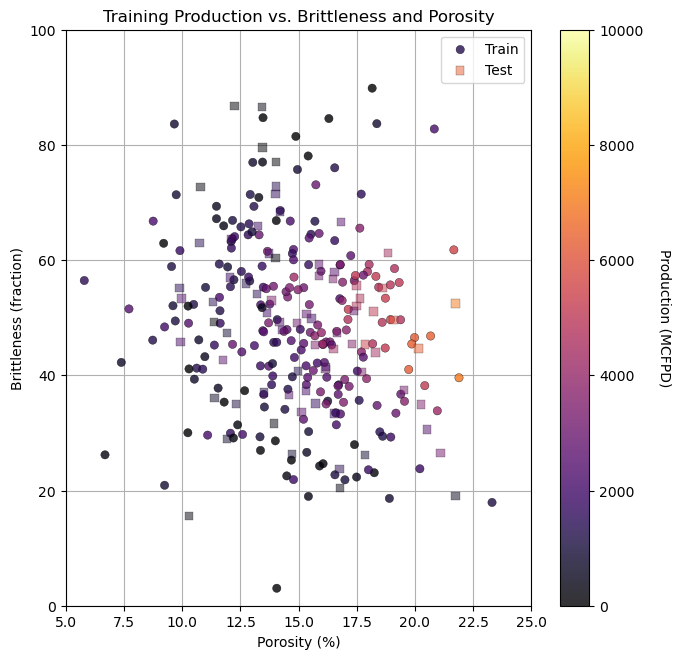

In [3]:
add_error = True                                        # add random error to the response feature
std_error = 700; seed = 71071

yname = 'Production'; Xname = ['Por','Brittle']         # specify the predictor features (x2) and response feature (x1)
Xmin = [5.0,0.0]; Xmax = [25.0,100.0]                   # set minumums and maximums for visualization 
ymin = 0.0; ymax = 10000.0
Xlabel = ['Porosity','Brittleness']; ylabel = 'Production' # specify the feature labels for plotting
Xunit = ['%','fraction']; yunit = 'MCFPD'
Xlabelunit = [Xlabel[0] + ' (' + Xunit[0] + ')',Xlabel[1] + ' (' + Xunit[1] + ')']
ylabelunit = ylabel + ' (' + yunit + ')'

df = pd.read_csv('https://raw.githubusercontent.com/daytum/intake-data/refs/heads/master/daytum_cat/data/unconv_MV.csv')                      # load the data from local current directory
#df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv") # load the data from my github repo
df = df.sample(frac=.30, random_state = 73073); df = df.reset_index() # extract 30% random to reduce the number of data

if add_error == True:                                   # method to add error
    np.random.seed(seed=seed)                           # set random number seed
    df[yname] = df[yname] + np.random.normal(loc = 0.0,scale=std_error,size=len(df)) # add noise
    values = df._get_numeric_data(); values[values < 0] = 0  # set negative to 0 in a shallow copy ndarray
    
y = pd.DataFrame(df[yname])                             # extract selected features as X and y DataFrames
X = df[Xname]
df = pd.concat([X,y],axis=1)                            # make one DataFrame with both X and y (remove all other features)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=73073) # train and test split
# y_train = pd.DataFrame({yname:y_train.values}); y_test = pd.DataFrame({yname:y_test.values}) # optional to ensure response is a DataFrame

plt.subplot(121)                                        # visualize the data
im = plt.scatter(X_train[Xname[0]],X_train[Xname[1]],s=None, c=y_train[yname], marker='o', cmap=cmap, 
    norm=None, vmin=ymin, vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black", label = 'Train')
plt.scatter(X_test[Xname[0]],X_test[Xname[1]],s=None, c=y_test[yname], marker='s', cmap=cmap, 
    norm=None, vmin=ymin, vmax=ymax, alpha=0.5, linewidths=0.3, edgecolors="black", label = 'Test')
plt.title('Training ' + ylabel + ' vs. ' + Xlabel[1] + ' and ' + Xlabel[0]); 
plt.xlabel(Xlabel[0] + ' (' + Xunit[0] + ')'); plt.ylabel(Xlabel[1] + ' (' + Xunit[1] + ')')
plt.xlim(Xmin[0],Xmax[0]); plt.ylim(Xmin[1],Xmax[1]); plt.legend(loc = 'upper right'); plt.grid(True)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(ylabel + ' (' + yunit + ')', rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Interactive Decision Tree Method

The following code includes a dashboard with widgets linked to plots to run a decision tree predictive machine learning model and to provide diagnostics.

* visualization of the decision tree regions with the estimate in each region annotated
* cross validation plot with conditional mean, P10 and P90 of the truth for each possible estimate
* the MSE train and test curves for hyperparameter tuning

In [4]:
l = widgets.Text(value='                                                Machine Learning Decision Tree Demo, Prof. Michael Pyrcz, The University of Texas at Austin',
        layout=Layout(width='900px', height='30px'))

max_leaf_nodes = widgets.IntSlider(min=2, max = 150, value=2, step = 1, description = r'$n_{leaf}$',orientation='horizontal', 
        style = {'description_width': 'initial'},layout=Layout(width='900px', height='30px'),continuous_update=False)

ui_summary = widgets.HBox([max_leaf_nodes,],)
ui2_summary = widgets.VBox([l,ui_summary],)

def run_plot_summary(max_leaf_nodes):
    global tree_model                                   # make the current tree model available for additional visualizations
    tree_model = tree.DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes) # instantiate and train tree model
    tree_model = tree_model.fit(X_train.values, y_train.values)
    
    plt.subplot(131)                                    # visualize, data, and decision tree regions and predictions
    visualize_tree_model(tree_model,X_train[Xname[0]],X_test[Xname[0]],X_train[Xname[1]],X_test[Xname[1]],Xmin,Xmax,
                    y_train[yname],y_test[yname],ymin,ymax,'Decision Tree Model',Xname,yname,Xlabelunit,ylabelunit) # plots the data points and the decision tree prediction 
    
    plt.subplot(132)                                    # cross validation with conditional statistics plot
    check_tree_model(tree_model,X_train[Xname[0]],X_test[Xname[0]],X_train[Xname[1]],X_test[Xname[1]],Xmin,Xmax,
                    y_train[yname],y_test[yname],ymin,ymax,'Decision Tree Model',)
    
    plt.subplot(133)                                    # hyperparameter tuning plot with current result plotted
    tree_tuning(100,max_leaf_nodes,X_train[Xname[0]],X_test[Xname[0]],X_train[Xname[1]],X_test[Xname[1]],Xmin,Xmax,
                    y_train[yname],y_test[yname],ymin,ymax,'Decision Tree Model Error',seed)
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.2)
    plt.savefig('interactive_decision_tree.png',bbox_inches='tight',dpi=300)  # Save as a PNG file  
    plt.show()
    return tree_model
    
# connect the function to make the samples and plot to the widgets    
interactive_plot_summary = widgets.interactive_output(run_plot_summary, {'max_leaf_nodes':max_leaf_nodes,})
interactive_plot_summary.clear_output(wait = True)                  

### Interactive Decision Tree Demonstration

* select maximum number of leaf nodes, $n_{leaf}$, and observe the decision tree model, cross validation plot and entire training and testing error curves.


### The Inputs

Change the complexity of the decision tree model

* $n_{leaf}$: the maximum number of leaf nodes

In [5]:
display(ui2_summary, interactive_plot_summary)                           # display the interactive plot

Output(outputs=({'output_type': 'display_data', 'metadata': {}, 'data': {'text/plain': '<Figure size 640x480 w…

#### Additional Tree Model Visualization

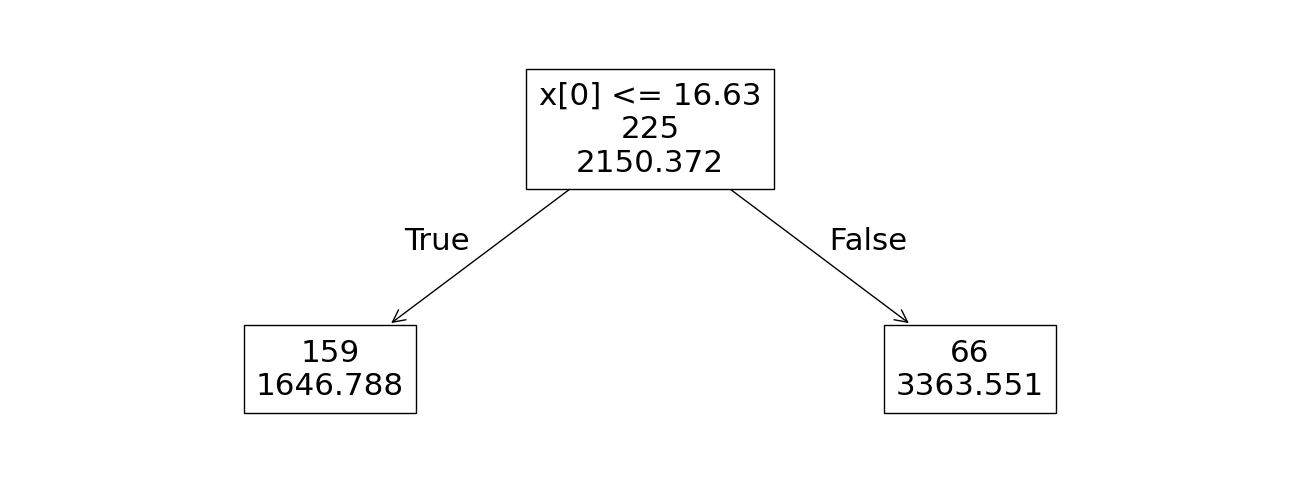

In [6]:
tree.plot_tree(tree_model,label='none',impurity=False)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was an interactive demonstration of predictive machine learning with decision trees. 